In [1]:
!nvidia-smi

Wed Oct  4 11:02:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [4]:
# Importing all the relevant libraries
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ROOT_PATH = '/content/drive/MyDrive'
!pwd

/content


In [7]:
import os
os.chdir(ROOT_PATH)
!pwd

/content/drive/MyDrive


In [8]:
os.getcwd()

'/content/drive/MyDrive'

In [12]:
ls

 best_model.h5
 Certificates/
 classes.txt
'Colab Notebooks'/
 data/
'Data Analyst.docx'
 Dataset/
 DJI_0137.txt
 DJI_0139.txt
 DJI_0142.txt
 DT20217602368_OL.pdf
 Images/
'January current affairs'/
 new.txt
 PetImages-20231004T111704Z-001/
 pw/
 pw2/
'RB siddharth chamoli.pdf'
 Resume/
'Siddharth_resume (1).pdf'
'Siddharth_resume (2).pdf'
 Siddharth_resume.docx
 Siddharth_resume.pdf
'Siddharth'\''s Res (1).pdf'
'Siddharth'\''s Res (2).pdf'
"Siddharth's Res.pdf"
'siddharth'\''s Resume (2).pdf'
"Siddharth's Resume.pdf"
'Tg-adapter & Interactive Logic_Java_Code.docx'
'Untitled0 (1).ipynb'
'UPSC Exam Comprehensive News Analysis. January 10th, 2021 CNA. Download PDF'
 Validation_Java_Code.docx
 yolov8s-seg/


In [13]:
image_size = [224,224]
train_path = 'PetImages-20231004T111704Z-001/PetImages/train'
test_path = 'PetImages-20231004T111704Z-001/PetImages/validation'

In [17]:
image_size+[3]

[224, 224, 3]

In [14]:
## Importing the vgg16 as first layer
vgg16 = VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [16]:
for layer in vgg16.layers:
  print(layer)

In [18]:
# Making layers untrainable and retaining original weights for layers
for layer in vgg16.layers:
  layer.trainable=False

In [19]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [20]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
# Getting training folder
train_folder = glob('PetImages-20231004T111704Z-001/PetImages/train/*')
train_folder

['PetImages-20231004T111704Z-001/PetImages/train/Cat',
 'PetImages-20231004T111704Z-001/PetImages/train/Dog']

In [23]:
len(train_folder)

2

In [24]:
from keras.api._v2.keras import activations
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])

In [27]:
# using data generators to load the images from dataset
train_generator = ImageDataGenerator(rescale=1./255,
                                     shear_range = 0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
test_generator = ImageDataGenerator(rescale=1./255)

In [28]:
train_set = train_generator.flow_from_directory('PetImages-20231004T111704Z-001/PetImages/train',
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 337 images belonging to 2 classes.


In [29]:
test_set = test_generator.flow_from_directory('PetImages-20231004T111704Z-001/PetImages/validation',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode= 'categorical')

Found 59 images belonging to 2 classes.


In [31]:
m = model.fit(train_set,
              validation_data =test_set,
              epochs=10,
              steps_per_epoch = len(train_set),
              validation_steps = len(test_set))

Epoch 1/10
11/11 [==============================] - 266s 23s/step - loss: 3.8363 - accuracy: 0.5401 - val_loss: 0.4247 - val_accuracy: 0.7966
Epoch 2/10
11/11 [==============================] - 5s 459ms/step - loss: 0.3943 - accuracy: 0.8160 - val_loss: 0.4098 - val_accuracy: 0.7966
Epoch 3/10
11/11 [==============================] - 5s 477ms/step - loss: 0.2179 - accuracy: 0.9021 - val_loss: 0.4282 - val_accuracy: 0.7966
Epoch 4/10
11/11 [==============================] - 5s 453ms/step - loss: 0.1837 - accuracy: 0.9139 - val_loss: 0.4094 - val_accuracy: 0.8136
Epoch 5/10
11/11 [==============================] - 6s 515ms/step - loss: 0.1263 - accuracy: 0.9466 - val_loss: 0.3956 - val_accuracy: 0.8136
Epoch 6/10
11/11 [==============================] - 6s 544ms/step - loss: 0.0938 - accuracy: 0.9763 - val_loss: 0.3761 - val_accuracy: 0.8305
Epoch 7/10
11/11 [==============================] - 7s 613ms/step - loss: 0.0752 - accuracy: 0.9911 - val_loss: 0.3740 - val_accuracy: 0.8305
Epoch 

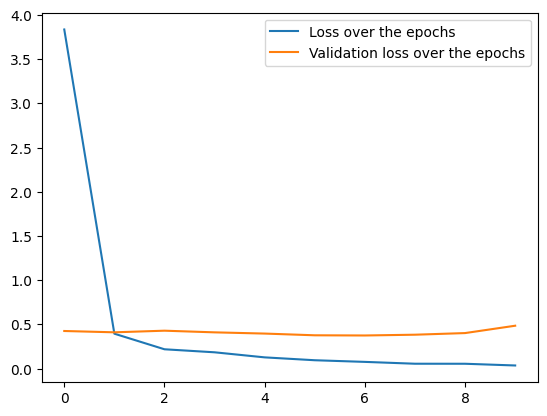

In [34]:
import matplotlib.pyplot as plt
plt.plot(m.history['loss'],label = 'Loss over the epochs')
plt.plot(m.history['val_loss'],label = 'Validation loss over the epochs')
plt.legend()
plt.show()

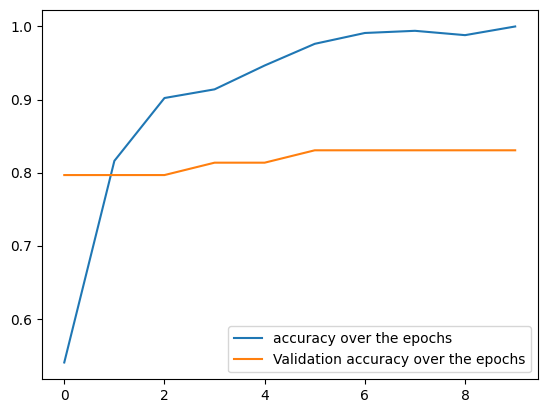

In [35]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'],label = 'accuracy over the epochs')
plt.plot(m.history['val_accuracy'],label = 'Validation accuracy over the epochs')
plt.legend()
plt.show()

In [36]:
from tensorflow.keras.models import load_model
import os
model.save(os.path.join('model','classifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
y_pred = model.predict(test_set)

2/2 [==============================] - 0s 150ms/step


In [39]:
np.argmax(y_pred,axis=1)

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0])

In [41]:
import shutil
shutil.copy('model_vgg16.h5','/content/')

'/content/model_vgg16.h5'

In [42]:
!gdown 'model_vgg16.h5'

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=model_vgg16.h5 

